In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
matplotlib.use('nbagg')
%matplotlib inline
import matplotlib.pyplot as plt

## Saving as a scenario

In [3]:
!ls -ltrh ../mat/*

-rw-r--r--  1 laurentperrinet  staff   118K Nov 30 14:16 ../mat/line_vague_solo.npy
-rw-r--r--  1 laurentperrinet  staff   104K Nov 30 14:16 ../mat/line_vague_dense.npy
-rw-r--r--  1 laurentperrinet  staff   1.4M Dec  2 16:00 ../mat/line_geometry_structure.npy
-rw-r--r--  1 laurentperrinet  staff   416K Dec  2 16:51 ../mat/line_onde_dense.npy
-rw-r--r--  1 laurentperrinet  staff   416K Dec  2 16:51 ../mat/line_onde_solo.npy
-rw-r--r--  1 laurentperrinet  staff   731K Dec  3 16:07 ../mat/line_fresnelastique.npy
-rw-r--r--  1 laurentperrinet  staff   731K Dec  3 16:07 ../mat/line_fresnelastique_chirp.npy
-rw-r--r--  1 laurentperrinet  staff   731K Dec  3 16:07 ../mat/line_fresnelastique_choc.npy
-rw-r--r--  1 laurentperrinet  staff   1.4M Dec  4 17:09 ../mat/line_geometry_90deg.npy
-rw-r--r--  1 laurentperrinet  staff   183K Dec  6 10:58 ../mat/line_contraint.npy


In [8]:
%%writefile ../scenario_line_master.py
#!/usr/bin/env python
# -*- coding: utf8 -*-

import elasticite as el
import numpy as np
import os

def master(e, filename):
    if e.structure: N_lame = e.N_lame-e.struct_N
    else: N_lame = e.N_lame

    def montage(z, z_in, damp_tau=0.):
        z_out = z.copy()
        z_s = z_in.copy()
        #if damp_tau>0:
        #    max_time = z_in.shape[0]/e.desired_fps
        #    time = np.linspace(0., max_time, z_in.shape[0])
        #    smooth = 1.-np.exp((np.cos(2*np.pi* time / max_time)-1)/(damp_tau / max_time)**2)
        #    z_s[:, 1:] *= smooth[:, np.newaxis]

        #print (z_out[0, 0], z_out[-1, 0], z_s[0, 0], z_s[-1, 0])
        z_s[:, 0] += z_out[-1, 0] + 1./e.desired_fps # increment the time on the new array
        #print (z_out.shape, z_s.shape, z_s[0, 0], z_s[-1, 0])
        return np.vstack((z_out, z_s))

    def revert(z_in):
        z_s = z_in.copy()
        z_s[:, 1:] = z_s[:, 1:][:, ::-1]
        return z_s

    def mirror(z_in):
        z_s = z_in.copy()
        z_s[:, 1:] = -z_s[:, 1:]
        return z_s

    def interleave(z_1, z_2):
        z_s_1 = z_1.copy()
        z_s_2 = z_2.copy()
        z_s_1[:, 1::2] = z_s_2[:, 1::2]
        return z_s_1
            
    matpath = 'mat/'
    z_s = {}
    print('importing scenarii')
    for scenario in [#'line_vague_dense', 'line_vague_solo', 
                     'line_onde_dense', 'line_onde_solo', 'line_fresnelastique',
                    'line_fresnelastique_choc', 'line_fresnelastique_chirp', 
                     'line_geometry', 'line_geometry_45deg', 'line_geometry_90deg', 'line_geometry_structure']:
        z_s[scenario] = np.load(os.path.join(matpath, scenario + '.npy'))
        print(scenario)
        el.check(e, z_s[scenario])
    print('finished importing scenarii')    
    ###########################################################################
    burnout_time = 0.1
    z = np.zeros((1, N_lame+1)) # zero at zero
    z = np.vstack((z, np.hstack((np.array(burnout_time), np.zeros(N_lame) ))))
    ###########################################################################
#    z = montage(z, z_s['line_onde_solo'])
    z = montage(z, z_s['line_onde_dense'])
    ###########################################################################
    z = montage(z, z_s['line_geometry_90deg'])
    z = montage(z, z_s['line_geometry_45deg'])
    z = montage(z, z_s['line_geometry_structure'])
    z = montage(z, z_s['line_geometry'])
    z = montage(z, mirror(z_s['line_geometry_structure']))
    z = montage(z, mirror(z_s['line_geometry_45deg']))
    z = montage(z, mirror(z_s['line_geometry_90deg']))
    ###########################################################################
#    z = montage(z, z_s['line_onde_solo'])
    z = montage(z, revert(z_s['line_onde_dense']))
#    z = montage(z, revert(z_s['line_onde_solo']))
    ###########################################################################
    z = montage(z, z_s['line_geometry_structure'])
    z = montage(z, z_s['line_geometry'])
    z = montage(z, z_s['line_fresnelastique'])
    z = montage(z, mirror(z_s['line_fresnelastique']))
    z = montage(z, z_s['line_fresnelastique_chirp'])
    z = montage(z, z_s['line_fresnelastique_choc'])
    z = montage(z, z_s['line_geometry'])
    z = montage(z, z_s['line_geometry_structure'])
    ###########################################################################
    z = montage(z, z_s['line_fresnelastique'])
    z = montage(z, interleave(z_s['line_fresnelastique'], mirror(z_s['line_fresnelastique'])))
    z = montage(z, interleave(z_s['line_fresnelastique_chirp'], mirror(z_s['line_fresnelastique_choc'])))
    z = montage(z, interleave(z_s['line_fresnelastique_choc'], mirror(z_s['line_fresnelastique_chirp'])))
    z = montage(z, z_s['line_fresnelastique'])
    ###########################################################################
    z = montage(z, revert(z_s['line_onde_dense']))
#    z = montage(z, revert(z_s['line_onde_solo']))
    ###########################################################################
    # check that there is not overflow @ 30 fps
    el.check(e, z)
    ###########################################################################
    # save the file
    np.save(filename, z)

    return z_s

if __name__ == "__main__":
    import sys
    if len(sys.argv)>1: mode = sys.argv[1]
    else: mode = 'both'
        
    filename = 'mat/master.npy'
    e = el.EdgeGrid(N_lame=25, grid_type='line', mode=mode,
                 verb=False, filename=filename)

    if mode == 'writer':
        z_s = master(e, filename)
    else:
        # running the code
        el.main(e)


Overwriting ../scenario_line_master.py


In [9]:
%cd ..
!rm mat/master.npy
%run  scenario_line_master.py writer
%cd posts

/Users/laurentperrinet/cloud_nas/science/elasticte
rm: mat/master.npy: No such file or directory
importing scenarii
line_onde_dense
line_onde_solo
line_fresnelastique
line_fresnelastique_choc
line_fresnelastique_chirp
line_geometry
line_geometry_45deg
line_geometry_90deg
line_geometry_structure
finished importing scenarii
/Users/laurentperrinet/cloud_nas/science/elasticte/posts


(0.0, 117745.0, 0.0, 3924.8999999999996)

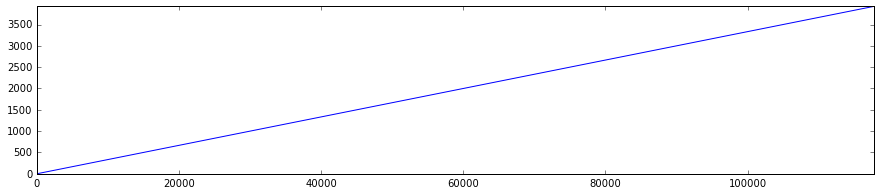

In [10]:
z = np.load('../mat/master.npy')
fig, ax = plt.subplots(figsize=(15, 3))
_ = ax.plot(z[:, 0])
ax.axis('tight')

(0.0, 3924.8999999999996, -1.5707963249932426, 1.5707963249932426)

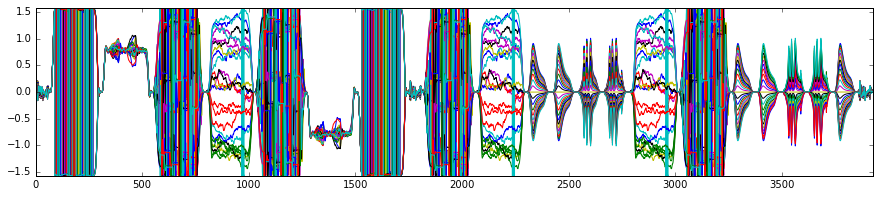

In [11]:
fig, ax = plt.subplots(figsize=(15, 3))
_ = ax.plot(z[:, 0], z[:, 1:])
ax.axis('tight')

## utile

7200 240.0
[ 0.          0.39508627  0.86180549  0.98691779  0.99940489  0.9999842
  0.99999969  0.99999999  1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          0.99999999
  0.99999969  0.9999842   0.99940489  0.98691779  0.86180549  0.39508627
  0.        ]


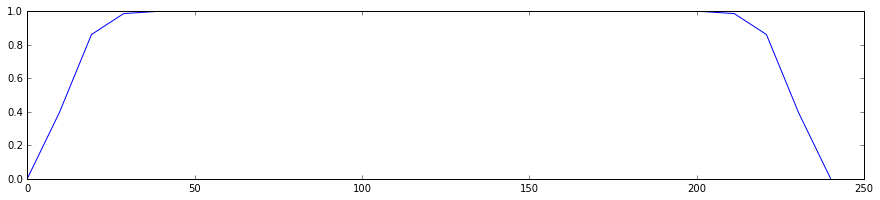

In [216]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
damp_tau = 60.
max_time = z_s['line_geometry'].shape[0]/e.desired_fps
time = np.linspace(0., max_time, z_s['line_geometry'].shape[-1])
print(z_s['line_geometry'].shape[0], max_time)
#smooth = 1.-np.exp(-(np.mod(time+max_time/2, max_time)-max_time/2)**2/damp_tau**2)
smooth = 1.-np.exp((np.cos(2*np.pi* time / max_time)-1)/(damp_tau / max_time)**2)
print (smooth)
fig, ax = plt.subplots(figsize=(15, 3))
_ = ax.plot(time, smooth)

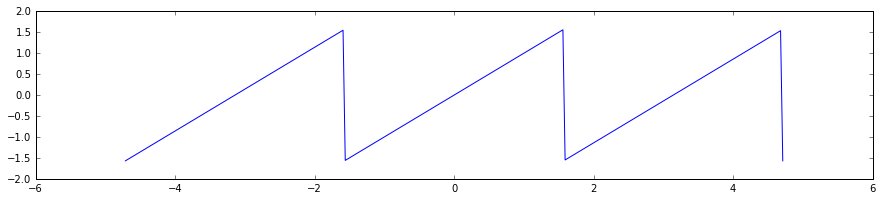

In [217]:
angle_actuel = np.linspace(-1.5*np.pi, 1.5*np.pi, 300)
angle_actuel_ = np.mod(angle_actuel + np.pi/2, np.pi) - np.pi/2
fig, ax = plt.subplots(figsize=(15, 3))
_ = ax.plot(angle_actuel, angle_actuel_)

## git


In [13]:
! git add ../mat/master.npy ../mat/line_*
!git s

A  ../mat/line_contraint.npy
A  ../mat/line_geometry.npy
A  ../mat/line_geometry_45deg.npy
M  ../mat/line_geometry_90deg.npy
A  ../mat/master.npy
 M ../scenario_line_master.py


In [14]:
!git commit -am' scenario master '

[master 8b49914]  scenario master
 6 files changed, 1 insertion(+), 1 deletion(-)
 create mode 100644 mat/line_contraint.npy
 create mode 100644 mat/line_geometry.npy
 create mode 100644 mat/line_geometry_45deg.npy
 rewrite mat/line_geometry_90deg.npy (82%)
 create mode 100644 mat/master.npy


In [ ]:
! git push

Counting objects: 9, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (9/9), done.


In [ ]:
%pwd